## 7. Multi-step Time Series Forecasting with ARIMA, LightGBM, and Prophet

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2021.10.28 </div>
<div style="text-align: right\"> Last update: 2021.10.28</div>

- 출처 : https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

다음 4가지의 데이터를 다룬다.  
- Cyclic time series (Sunspots data)
- Time Series without trend and seasonality (Nile dataset)
- Time series with a strong trend (WPI dataset)
- Time series with trend and seasonality (Airline dataset)

### 1. Cyclic Time Series (Sunspots data)

In [3]:
import statsmodels.api as sm

In [4]:
data = sm.datasets.sunspots.load_pandas()

In [5]:
data.data

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


In [6]:
# pd.series 형태로
ts_sun = data.data.set_index('YEAR')['SUNACTIVITY']

In [7]:
ts_sun

YEAR
1700.0     5.0
1701.0    11.0
1702.0    16.0
1703.0    23.0
1704.0    36.0
          ... 
2004.0    40.4
2005.0    29.8
2006.0    15.2
2007.0     7.5
2008.0     2.9
Name: SUNACTIVITY, Length: 309, dtype: float64

<AxesSubplot:xlabel='YEAR'>

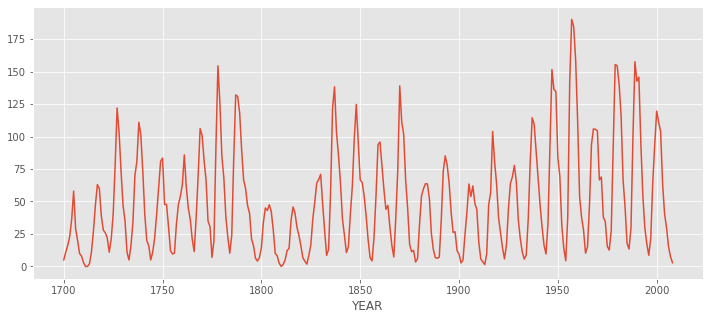

In [8]:
ts_sun.plot(figsize =(12, 5) )

먼저 시계열의 stationarity를 파악한다. stationary는 시계열이 시간이 지남에 따라 평균과 분산이 변하기 않는 것을 의미한다.   
주기성cyclic을 가지는 시계열은 일반적으로 stationary이다. 반면 트렌드나 계절성seasonality을 가지는 데이터는 stationary가 아니다.   

선형모델이나 ARIMA 같은 것을 사용하기 위해 데이터가 stationary timeseries인지 확인하는 것이 중요하다.

elow we are setting up and executing a function that shows autocorrelation (ACF) and partial autocorrelation (PACF) plots along with performing Augmented Dickey–Fuller unit test.

In [9]:
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

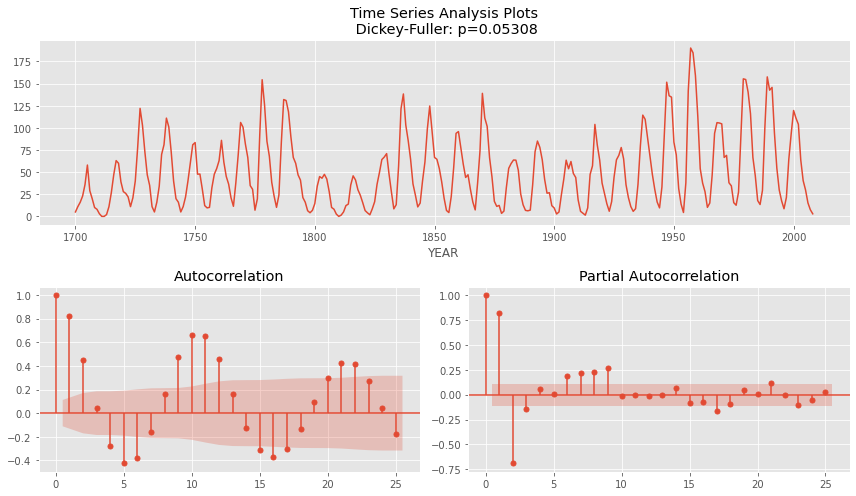

In [10]:
tsplot(ts_sun)

ACF는 시계열이 stationary인지 확인하기 위한 것이다. 그리고 ARIMA에서 autoregressive 파트의 차수를 찾는데 유용하다.   
PACF는 moving average의 차수를 찾는데 유용하다.   
Augmented Dickey–Fuller unit test는 시계열이 non-stationary인지 아닌지 시험하는데 유용하다.    

The null hypothesis is that the series is non-stationary, hence if the p-value is small, it implies the time series is NOT non-stationary.

In the picture above, Dickey-Fuller test p-value is not significant enough (> 5%). We are going to take the first difference to make the series more stationary.  ???

p 값이 충분히 작지않아서 시계열을 stationary하게 만들기 위해서 1차 차분을 진행한다.

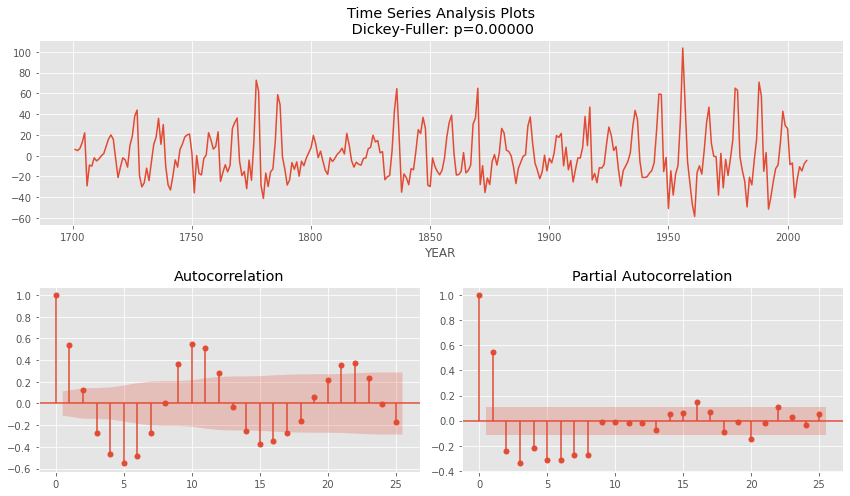

In [11]:
ts_sun_diff = (ts_sun - ts_sun.shift(1)).dropna()
tsplot(ts_sun_diff)

- p 값이 작어서 stationary 해졌다.  

ACF가 사인파 형태를 보이고 PACF가 lag 8까지 늘어났다.???  이말은 ARIMA(8, 1, 0)을 사용하면 된다는 뜻이다.   
ACF, PACF로 차수를 결정하는 방법은 아래를 참고하자.   
- https://otexts.com/fpp3/non-seasonal-arima.html#acf-and-pacf-plots

다음단계는 자동으로 arima의 파라미터를 찾아주는 sktime의 AutoArima를 사용하는 것이다.   

 the plot analysis above to find the right orders on ARIMA parameters looks unnecessary, but it still helps us to determine the search range of the parameter orders and also enables us to verify the outcome of AutoARIMA.

모델링을 하기 전에 데이터 셋을 8: 2로 분리한다.

In [12]:
test_len = int(len(ts_sun) * 0.2)
sun_train, sun_test = ts_sun.iloc[:-test_len], ts_sun.iloc[-test_len:]

#### 1.1 ARIMA on Sunspots dataset

ARIMA는 과거 값의 series를 이용하고(autoregression), 과거의 예측오차들을 사용한다.(moving average)   
모델은 p, d, p 3개의 파라미터를 사용한다. 
- p : autoregressive의 차수  
- d : 1차 미분의 차수  
- q : moving average의 차수
    
We are using sktime’s AutoARIMA here which is a wrapper of pmdarima and can find those ARIMA parameters (p, d, q) automatically. pmdarima is a Python project which replicates R’s auto.arima functionality. You can see how auto.arima automatically tunes the parameters in this link. As the analysis above suggests ARIMA(8,1,0) model, we set start_p and max_p with 8 and 9 respectively.

여기서는 앞에서 사용한 (8, 1, 0)을 시작점으로 사용한다.

In [13]:
from sktime.forecasting.arima import AutoARIMA

In [14]:
forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)

In [15]:
sun_train

YEAR
1700.0      5.0
1701.0     11.0
1702.0     16.0
1703.0     23.0
1704.0     36.0
          ...  
1943.0     16.3
1944.0      9.6
1945.0     33.2
1946.0     92.6
1947.0    151.6
Name: SUNACTIVITY, Length: 248, dtype: float64

In [16]:
sun_train.index = sun_train.index.astype(int)

In [17]:
forecaster.fit(sun_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  248
Model:               SARIMAX(8, 0, 1)   Log Likelihood               -1005.432
Date:                Mon, 15 Nov 2021   AIC                           2032.863
Time:                        17:11:23   BIC                           2071.511
Sample:                             0   HQIC                          2048.421
                                - 248                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3721      2.482      1.359      0.174      -1.493       8.237
ar.L1          1.6993      0.217      7.836      0.000       1.274       2.124
ar.L2         -1.0801      0.292     -3.695      0.000      -1.653      -0.507
ar.L3          0.1148      0.168      0.682      0.496      -0.215       0.445
ar.L4          0.2228      0.168      1.329      0.184      -0.106       0.552
ar.L5         -0.2164      0.175     -1.233      0.218      -0.560       0.128
ar.L6          0.1115      0.160      0.696      0.487      -0.203       0.426
ar.L7         -0.0785      0.159     -0.493      0.622      -0.391       0.234
ar.L8          0.1515      0.109      1.393      0.164      -0.062       0.365
ma.L1         -0.4613      0.216     -2.139      0.032      -0.884      -0.039
sigma2       191.6638     14.255     13.445      0.000     163.725     219.603
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                43.16
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.62
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

앞에서의 우리의 예상과 약간 다른 결과가 나왔다.

모델은 (8, 0, 1)이 최적이라고 출력하였다.

이제 MAE와 MAPE를 적용하여 예측과 동시에 성능을 평가하는 함수를 구현해보자.

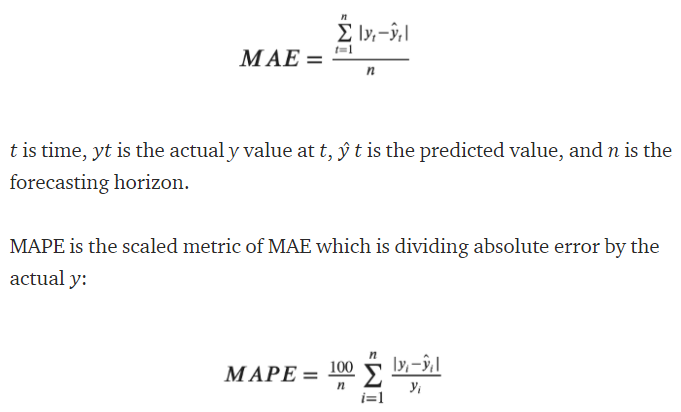

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [34]:
def plot_forecast(train, test, forecast, forecast_int = None):
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    
    plt.figure(figsize=(12, 5))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=16)
    train.plot(label = 'train', color = 'b', alpha = 0.7)
    test.plot(label = 'test', color = 'g', alpha = 0.7)
    forecast.index = test.index
    test.plot(label = 'test', color = 'g', alpha = 0.7)
    forecast.plot(label = 'forecast', color = 'r', alpha=0.7)
    
    if forecast_int is not None:
        plt.fill_between(test.index, forecast_int["lower"], forecast_int["upper"], 
                         alpha=0.2, color="dimgray")
    plt.legend(prop={"size": 12})
    plt.show()
    
    return mae, mape

In [35]:
fh = np.arange(test_len) + 1

In [36]:
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [37]:
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)

In [38]:
forecast

1948    159.465739
1949    133.183839
1950     92.745428
1951     54.600766
1952     23.179444
           ...    
2004     43.970760
2005     37.695599
2006     34.526200
2007     35.297566
2008     39.487176
Length: 61, dtype: float64

In [39]:
forecast_int

,lower,upper
1948,132.331468,186.600010
1949,89.999611,176.368067
1950,41.396301,144.094556
1951,1.366168,107.835364
1952,-30.187756,76.546644
...,...,...
2004,-27.849061,115.790581
2005,-34.124317,109.515515
2006,-37.310365,106.362764
2007,-36.582411,107.177544


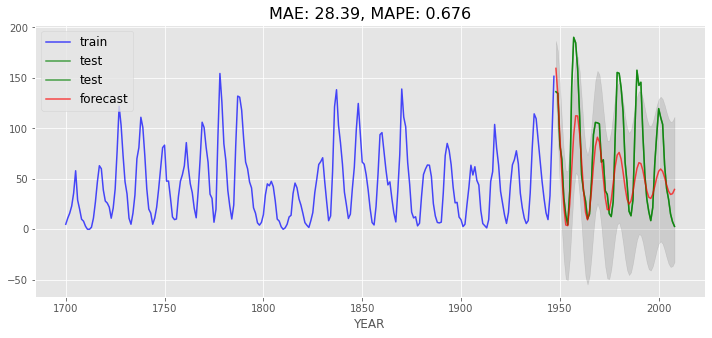

In [40]:
sun_arima_mae, sun_arima_mape = plot_forecast(sun_train, sun_test, forecast, forecast_int)

#### 1.2 LightGBM on Sunspots dataset

lgbm 적용을 위해 시계열을 tabular로 변환해야한다.  
먼저 lag 변수를 추가하는 것이다. 그리고 모델이 한스텝만 예측하므로 예측 결과를 사용해서 다음 스텝을 예측하도록 해야한다. 이것을 recursive approach for multi-step forecasting 이라고 한다.   
sktime 패키지를 사용하면 앞에 설명한 것을 쉽게 구현가능하다.  
특히 make_reduction 함수를 사용하면 LGBMRegressor 함수를 wrapping하여 시계열을 tabular로 변환한다.  
그리고 ForecastingGridSearchCV 함수로 최적의 윈도우 lag 길이를 찾을 수 있다.

In [41]:
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
import lightgbm as lgb

In [42]:
def create_forecaster():
    
    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
    
    return forecaster

In [43]:
def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
    fh=np.arange(len(test))+1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape

best params: {'window_length': 20}


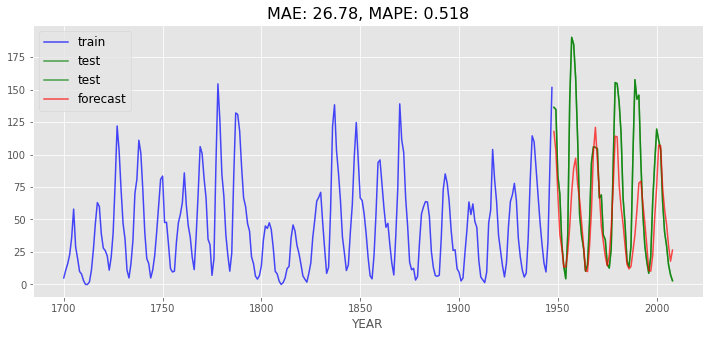

In [44]:
param_grid = {"window_length": [5, 10, 15, 20, 25, 30]} # parameter set to be grid searched
forecaster = create_forecaster()
sun_lgb_mae, sun_lgb_mape = grid_serch_forecaster(sun_train, sun_test, forecaster, param_grid)


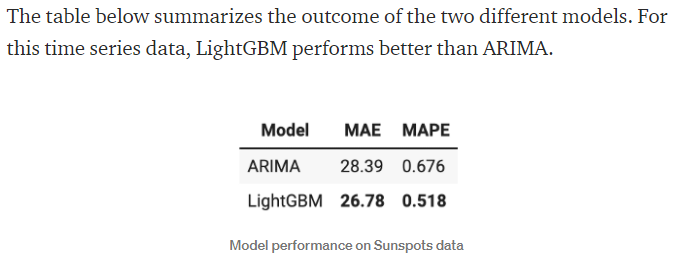

### 2. Time Series without trend and seasonality (Nile Dataset)

In [45]:
ts_nl = sm.datasets.get_rdataset('Nile').data

In [46]:
ts_nl

,time,value
0,1871,1120
1,1872,1160
2,1873,963
3,1874,1210
4,1875,1160
...,...,...
95,1966,746
96,1967,919
97,1968,718
98,1969,714


In [47]:
ts_nl = ts_nl.set_index('time')

In [48]:
ts_nl.head()

,value
time,
1871,1120
1872,1160
1873,963
1874,1210
1875,1160


In [50]:
ts_nl = ts_nl.reset_index()

In [52]:
ts_nl = ts_nl.set_index('time').value

In [53]:
ts_nl

time
1871    1120
1872    1160
1873     963
1874    1210
1875    1160
        ... 
1966     746
1967     919
1968     718
1969     714
1970     740
Name: value, Length: 100, dtype: int64

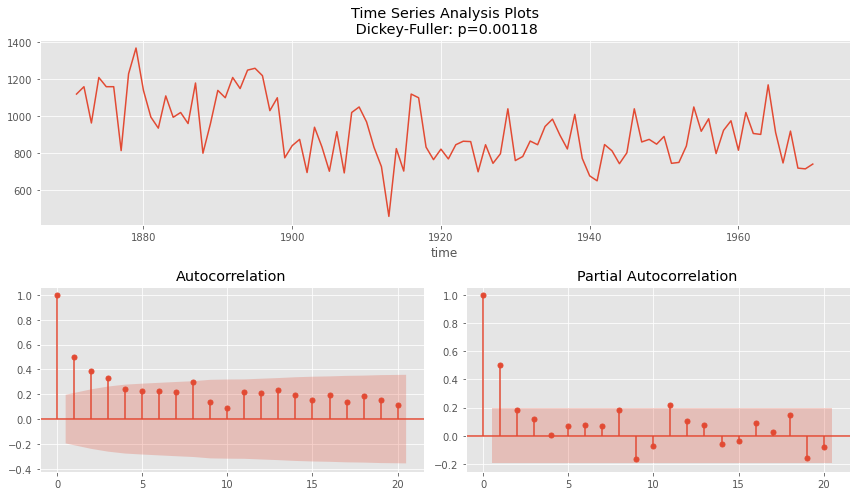

In [54]:
tsplot(ts_nl)

While Dickey-Fuller test implies it’s stationary, there is some autocorrelation as can be seen in ACF plot. We are trying to see how its first difference looks like.

In [55]:
ts_nl_diff = (ts_nl - ts_nl.shift(1)).dropna()

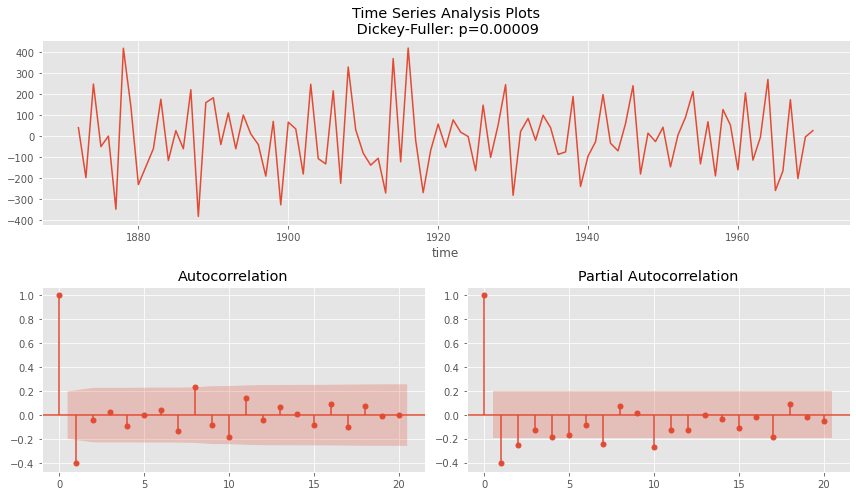

In [56]:
tsplot(ts_nl_diff)